In [1]:
!pip uninstall datasets huggingface_hub fsspec -y
!pip install --upgrade pip setuptools wheel
!pip install datasets==2.18.0 huggingface_hub==0.20.3 fsspec==2023.10.0




Found existing installation: datasets 2.18.0
Uninstalling datasets-2.18.0:
  Successfully uninstalled datasets-2.18.0
Found existing installation: huggingface-hub 0.20.3
Uninstalling huggingface-hub-0.20.3:
  Successfully uninstalled huggingface-hub-0.20.3
Found existing installation: fsspec 2023.10.0
Uninstalling fsspec-2023.10.0:
  Successfully uninstalled fsspec-2023.10.0
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (6.8 kB)
Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
Using cached huggingface_hub-0.20.3-py3-none-any.whl (330 kB)
Using cached fsspec-2023.10.0-py3-none-any.whl (166 kB)


In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import load_dataset
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import sqrtm


/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn

class LowRankLinear(nn.Module):
    def __init__(self, in_features, out_features, rank=1):
        super().__init__()
        self.u = nn.Parameter(torch.empty(out_features, rank))
        self.v = nn.Parameter(torch.empty(in_features, rank))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.u, mean=0.0, std=1e-1)
        nn.init.normal_(self.v, mean=0.0, std=1e-1)

    def forward(self, x):
        W = self.u @ self.v.T  # (out, in)
        return x @ W.T  # (batch, in) @ (in, out).T = (batch, out)


In [3]:
def make_weight_list(samples=16, epochs=100):
    weights_samples_1 = []
    weights_samples_2 = []
    weights_samples_fc = []

    for _ in tqdm(range(samples)):
        # Step 1: Load the TREC dataset
        dataset = load_dataset("trec", split="train")
        dataset = dataset.train_test_split(test_size=0.2)
        train_data = dataset['train']
        val_data = dataset['test']

        # Step 2: Preprocess the data with a tokenizer
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        def preprocess(data):
            return tokenizer(data['text'], truncation=True, padding=True, max_length=32)

        train_data = train_data.map(preprocess, batched=True)
        val_data = val_data.map(preprocess, batched=True)

        train_data = train_data.rename_column("coarse_label", "label")
        val_data = val_data.rename_column("coarse_label", "label")

        train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        # Step 3: Create DataLoaders
        def collate_fn(batch):
            # Ensure all input tensors have the same length by padding them dynamically
            input_ids = torch.nn.utils.rnn.pad_sequence([b['input_ids'] for b in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
            attention_mask = torch.nn.utils.rnn.pad_sequence([b['attention_mask'] for b in batch], batch_first=True, padding_value=0)
            labels = torch.tensor([b['label'] for b in batch])
            return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

        train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_data, batch_size=16, collate_fn=collate_fn)

        # Step 4: Define a custom PyTorch model
        class CustomClassifier(nn.Module):
            def __init__(self, input_dim, hidden_dim, num_classes, num_attention_layers=2, vocab_size=30522):
                super(CustomClassifier, self).__init__()
                
                # Embedding layer to map token IDs to embeddings
                self.embedding = nn.Embedding(vocab_size, input_dim)  # vocab_size is typically 30522 for BERT
                
                # Define a list to store multiple attention layers
                self.attention_layers = nn.ModuleList([LowRankLinear(input_dim, hidden_dim) for _ in range(num_attention_layers)])


                # Final fully connected layer for classification
                self.fc = nn.Linear(input_dim, num_classes)


            def _attention_layer(self, x, layer):
                # Project the input using the hidden layer
                x_new = self.attention_layers[layer](x)

                # Self attention (scaled dot-product)
                attention_scores = torch.matmul(x_new, x_new.transpose(1, 2)) / x_new.size(-1) ** 0.5  # Scaled attention scores
                attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

                # Apply attention weights to each input in the batch
                x = torch.einsum("nij,njd->nid", attention_weights, x)
                return x

            def forward(self, input_ids, attention_mask):
                # Get the embeddings from the input IDs
                embedded = self.embedding(input_ids)
                
                # Apply attention layers
                for layer in range(len(self.attention_layers)):
                    embedded = self._attention_layer(embedded, layer)
                
                # Mean pooling (average the token embeddings across the sequence)
                pooled_output = embedded.mean(dim=1)  # Average over the token dimension
                
                # Pass through the final fully connected layer
                logits = self.fc(pooled_output)
                return logits

        model = CustomClassifier(input_dim=1024, hidden_dim=256, num_classes=6)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Step 5: Define optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=5e-5)
        criterion = torch.nn.CrossEntropyLoss()

        weights_attention_1 = []
        weights_attention_2 = []
        weights_fc = [] 


        # Step 6: Train the model
        def train(epoch):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                weights_attention_1.append((model.attention_layers[0].u @ model.attention_layers[0].v.T).data.cpu().numpy())
                weights_attention_2.append((model.attention_layers[1].u @ model.attention_layers[1].v.T).data.cpu().numpy())

                weights_fc.append(model.fc.weight.data.cpu().numpy())

            if epoch % 10 == 0:
                print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


        # Step 7: Evaluate the model
        def evaluate(eph):
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    logits = model(input_ids=input_ids, attention_mask=attention_mask)
                    predictions = torch.argmax(logits, dim=-1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)
            if epoch % 10 == 0:
                print(f"Validation Epoch {epoch}: Accuracy = {correct / total:.4f}")

        # Run training and evaluation
        for epoch in range(epochs):
            train(epoch)
            evaluate(epoch)

        weights_samples_1.append(weights_attention_1)
        weights_samples_2.append(weights_attention_2)
        weights_samples_fc.append(weights_fc)

    return weights_samples_1, weights_samples_2, weights_samples_fc




def make_distance_measure(weights_attention_1, weights_attention_2, weights_fc):

    dist_1 = np.zeros(len(weights_attention_1))
    dist_2 = np.zeros(len(weights_attention_1))
    dist_3 = np.zeros(len(weights_fc))

    norm_1 = np.zeros((weights_attention_1[0].shape[0], weights_attention_1[0].shape[0]))
    norm_2 = np.zeros_like(norm_1)
    mag_1 = np.zeros_like(norm_1)
    mag_2 = np.zeros_like(norm_1)

    norm_1_final = np.linalg.norm(weights_attention_1[-1], axis=1)
    norm_2_final = np.linalg.norm(weights_attention_2[-1], axis=1)


    ### THIS USES SQUARED WEIGHTS
    weights_attention_1_squared = []
    weights_attention_2_squared = []
    weights_fc_squared = []

    for i in tqdm(range(len(weights_attention_1))):
        weights_attention_1_squared.append(np.einsum("pi,qi->pq", weights_attention_1[i],weights_attention_1[i]))
        weights_attention_2_squared.append(np.einsum("pi,qi->pq", weights_attention_2[i],weights_attention_2[i]))
        weights_fc_squared.append(np.einsum("pi,qi->pq", weights_fc[i], weights_fc[i]))


    norm_1_final = np.linalg.norm(weights_attention_1_squared[-1], ord="fro")
    norm_2_final = np.linalg.norm(weights_attention_2_squared[-1], ord="fro")
    norm_3_final = np.linalg.norm(weights_fc_squared[-1], ord="fro")      
    

    for i in tqdm(range(len(weights_attention_1))):
        norm_1 = np.linalg.norm(weights_attention_1_squared[i], ord="fro")
        norm_2 = np.linalg.norm(weights_attention_2_squared[i], ord="fro")
        norm_3 = np.linalg.norm(weights_fc_squared[i], ord="fro")

        mag_1 = np.einsum("pq,qk->pk", weights_attention_1_squared[i],weights_attention_1_squared[-1])
        mag_2 = np.einsum("pq,qk->pk", weights_attention_2_squared[i],weights_attention_2_squared[-1])
        mag_3 = np.einsum("pq,qk->pk", weights_fc_squared[i], weights_fc_squared[-1])

        dist_1[i] = np.trace(mag_1)/norm_1_final/norm_1
        dist_2[i] = np.trace(mag_2)/norm_2_final/norm_2
        dist_3[i] = np.trace(mag_3) / norm_3_final / norm_3

    return dist_1, dist_2, dist_3


In [ ]:
samples = 1
epochs = 81

# Ajout : récupération de weights_fc
weights_samples_1, weights_samples_2, weights_samples_fc = make_weight_list(samples, epochs)

# Initialisation des tableaux de distance
T = len(weights_samples_1[0])  # nombre d'epochs (ou itérations de suivi)
dist_samples_1 = np.zeros((samples, T))
dist_samples_2 = np.zeros((samples, T))
dist_samples_fc = np.zeros((samples, T))

# Calcul des similarités pour chaque run
for i in tqdm(range(samples)):
    dist_samples_1[i], dist_samples_2[i], dist_samples_fc[i] = make_distance_measure(
        weights_samples_1[i],
        weights_samples_2[i],
        weights_samples_fc[i]
    )


  0%|          | 0/5 [00:00<?, ?it/s]/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Map: 100%|██████████| 1091/1091 [00:00<00:00, 27760.84 examples/s]
/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Loss = 1.4035
Validation Epoch 0: Accuracy = 0.3492
Epoch 10: Loss = 1.3840
Validation Epoch 10: Accuracy = 0.6196
Epoch 20: Loss = 1.1100
Validation Epoch 20: Accuracy = 0.6664
Epoch 30: Loss = 0.5584
Validation Epoch 30: Accuracy = 0.6709
Epoch 40: Loss = 0.8108
Validation Epoch 40: Accuracy = 0.6783
Epoch 50: Loss = 0.6190
Validation Epoch 50: Accuracy = 0.6865
Epoch 60: Loss = 0.3455
Validation Epoch 60: Accuracy = 0.6874
Epoch 70: Loss = 0.5894
Validation Epoch 70: Accuracy = 0.6920


 20%|██        | 1/5 [02:36<10:25, 156.47s/it]

Epoch 80: Loss = 0.1244
Validation Epoch 80: Accuracy = 0.6874


Map: 100%|██████████| 1091/1091 [00:00<00:00, 26384.59 examples/s]


Epoch 0: Loss = 1.3429
Validation Epoch 0: Accuracy = 0.4097
Epoch 10: Loss = 1.1965
Validation Epoch 10: Accuracy = 0.5582
Epoch 20: Loss = 0.4782
Validation Epoch 20: Accuracy = 0.5820


: 

In [7]:
np.save("realistic_dist_samples_1.npy", dist_samples_1)
np.save("realistic_dist_samples_2.npy", dist_samples_2)
np.save("realistic_dist_samples_fc.npy", dist_samples_fc)


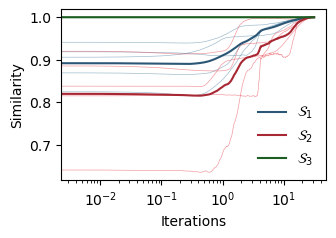

In [8]:
colors = ["#457B9D", "#E63946", "#2C5675", "#A72833","#1B5E20"]
plt.figure(figsize=(3.416, 2.216))

dist_samples_1 = np.load("realistic_dist_samples_1.npy")
dist_samples_2 = np.load("realistic_dist_samples_2.npy")
dist_samples_fc = np.load("realistic_dist_samples_fc.npy")

abs = np.linspace(0, epochs, dist_samples_1.shape[1])


plt.plot(abs, dist_samples_1.T, color=colors[0], lw=0.5, alpha=0.5)
plt.plot(abs, dist_samples_2.T, color=colors[1], lw=0.5, alpha=0.5)
plt.plot(abs, dist_samples_fc.T, color=colors[2], lw=0.5, alpha=0.5)

plt.plot(abs, dist_samples_1.mean(axis=0), label=r"$\mathcal{S}_1$", color=colors[2])
plt.plot(abs, dist_samples_2.mean(axis=0), label=r"$\mathcal{S}_2$", color=colors[3])
plt.plot(abs, dist_samples_fc.mean(axis=0), label=r"$\mathcal{S}_3$", color=colors[4])

plt.legend(frameon=False)
plt.xlabel("Iterations")
plt.ylabel("Similarity")
plt.xscale('log')
plt.show()